### Notebook for optimal initial sampling for material composition -> properties problem. 4 dimensions

written by Christina Schenk

last updated on 09/01/2025

tested on Christina's M1 Mac

#### import python packages

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import qmc
import lhsmdu
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import csv
import sys
sys.path.append("../../../CASTRO/src")
from plot import *
from conditionedSampling import *
from utils import *

### Setting up a Single-Task GP Autonomous Data Acquisition Run

##### Specify the design space: lower and upper bounds for x and y, number of points at which we want to predict

In [2]:
#Lower and upper bounds for x and y:
#polymer:
PA56_lb = 0.8
PA56_ub = 1.0
#phytic acid:
PhA_lb = 0.0
PhA_ub = 0.05
#amino-based acids:
am_lb = 0.0
am_ub = 0.1
#metallic-based acids:
met_lb = 0.0
met_ub = 0.14


#dimension of design space:
dim = 4

#number of samples
n_samp = 170

x1_lb = PA56_lb
x1_ub = PA56_ub

x2_lb = PhA_lb
x2_ub = PhA_ub

x3_lb = am_lb
x3_ub = am_ub

x4_lb = met_lb
x4_ub = met_ub
bounds = [[x1_lb,x1_ub], [x2_lb,x2_ub], [x3_lb,x3_ub], [x4_lb,x4_ub]]

#### Latin Hypercube sampling on domain with variables summing up to 1: Sequentially and infeasible ones rejected/removed from sample set: 

In [3]:
import numpy as np
from scipy.stats import qmc

# Define the number of samples and the number of dimensions
n_samp = 90  # Adjust as needed
n_dim = 4      # 9 dimensions
seeds = [42, 123, 7, 99, 56]  # List of random seeds


# Function to normalize the samples
def normalize(samples):
    return samples / samples.sum(axis=1, keepdims=True)

# Function to scale the normalized samples while maintaining the sum constraint
def scale_and_renormalize(samples, bounds):
    scaled_samples = np.zeros_like(samples)
    for i, (lb, ub) in enumerate(bounds):
        scaled_samples[:, i] = lb + samples[:, i] * (ub - lb)
    # After scaling, renormalize to ensure the sum is exactly 1
    return scaled_samples / scaled_samples.sum(axis=1, keepdims=True)

# List to store the scaled samples from each seed
all_scaled_samples = []

# Generate samples for each seed
for seed in seeds:
    # Step 1: Create Latin Hypercube sampler with the current seed
    sampler = qmc.LatinHypercube(d=n_dim, seed=seed)
    
    # Step 2: Generate Latin Hypercube samples
    samples = sampler.random(n=n_samp)
    
    # Step 3: Normalize the samples
    samples_normalized = normalize(samples)
    
    # Step 4: Scale and renormalize the samples
    scaled_samples = scale_and_renormalize(samples_normalized, bounds)
    
    # Store the scaled samples
    all_scaled_samples.append(scaled_samples)

# Stack all the samples along a new axis (shape: num_seeds x n_samp x n_dim)
all_scaled_samples = np.stack(all_scaled_samples, axis=0)

# Compute the mean and standard deviation across the seeds (axis=0)
mean_samples = np.mean(all_scaled_samples, axis=0)
std_samples = np.std(all_scaled_samples, axis=0)

# Verify the shapes of the results
print(f"\nShape of mean samples: {mean_samples.shape}")
print(f"Shape of std samples: {std_samples.shape}")

# Print the mean and standard deviation of the first 5 samples
print("\nMean of the first 5 samples:")
print(mean_samples[:5])


Shape of mean samples: (90, 4)
Shape of std samples: (90, 4)

Mean of the first 5 samples:
[[0.90999    0.01290838 0.03260835 0.04449327]
 [0.91340834 0.01967252 0.02835502 0.03856412]
 [0.92885027 0.02260745 0.01119383 0.03734845]
 [0.92510028 0.01912222 0.02415241 0.03162509]
 [0.91842698 0.01517639 0.03424017 0.03215646]]


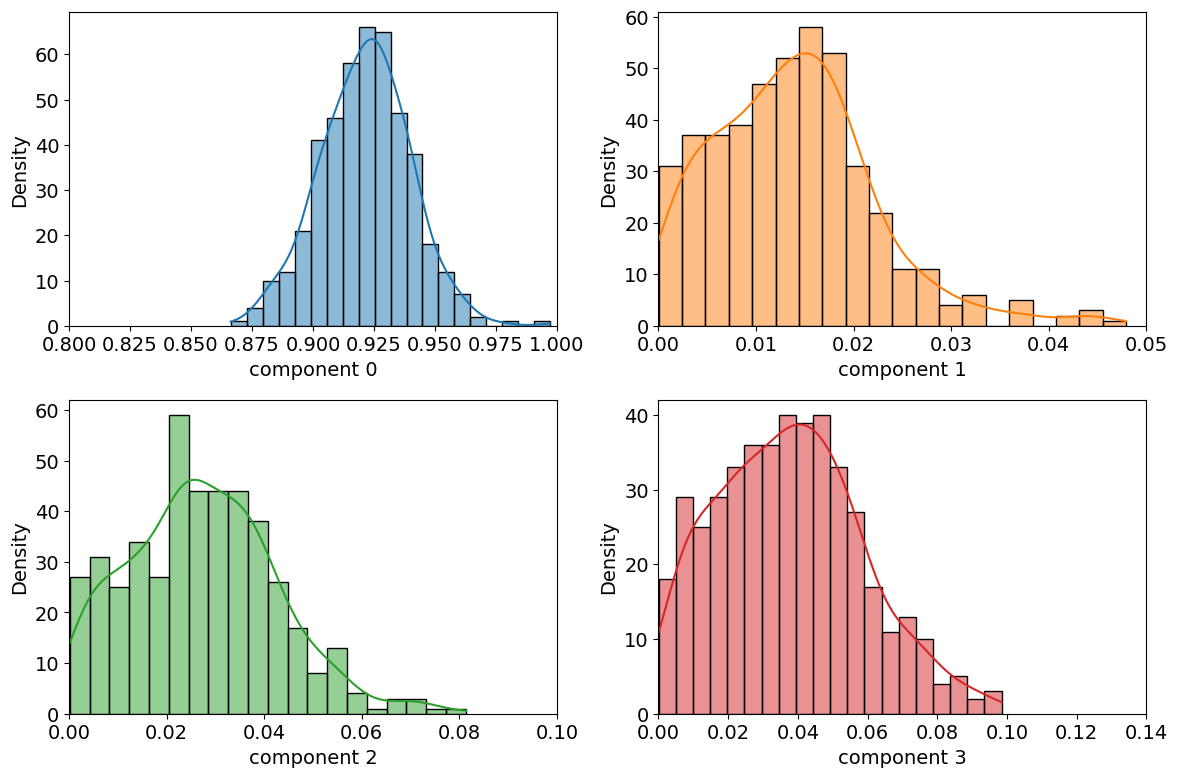

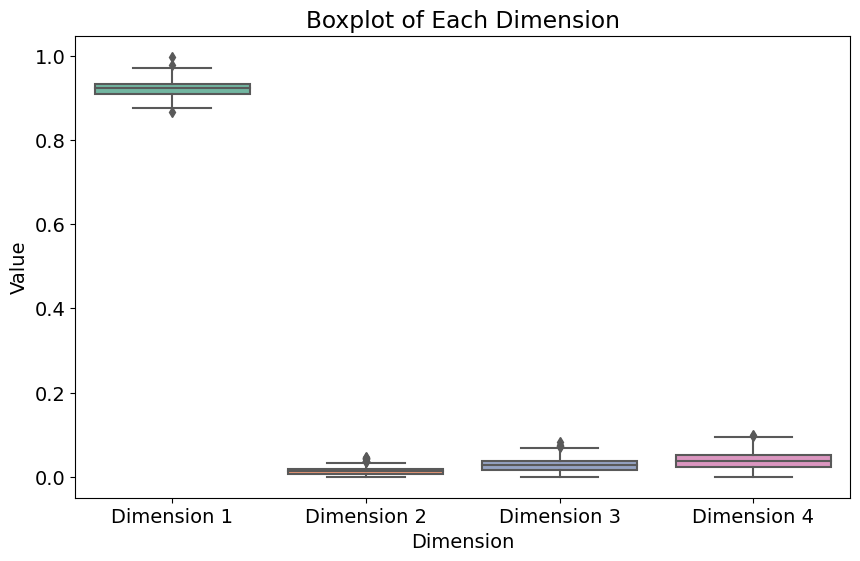

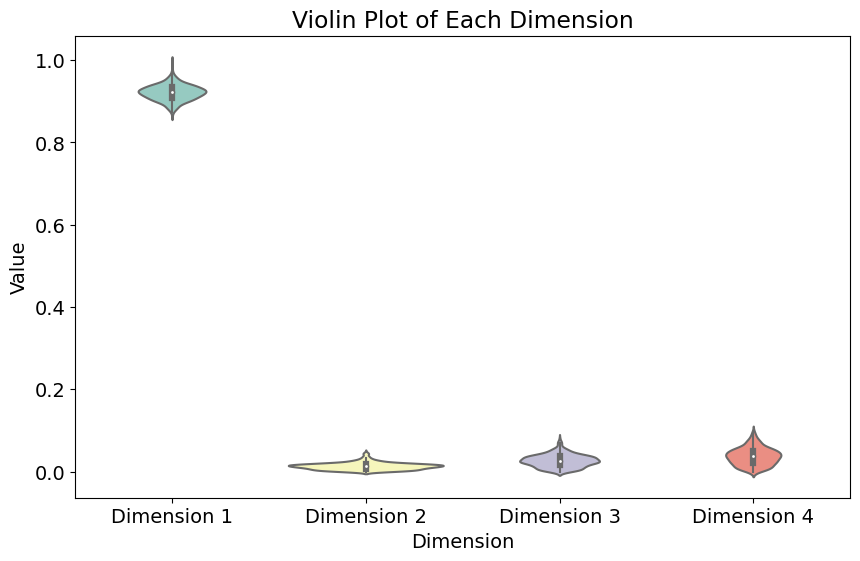

In [4]:
# Combine all samples into a single array (shape: num_seeds * n_samp, n_dim)
combined_samples = all_scaled_samples.reshape(-1, n_dim)

# Plot settings
#sns.set(style="whitegrid")
dim_labels = [f"Dimension {i+1}" for i in range(n_dim)]

# Plot 1: Histograms for each dimension
plt.figure(figsize=(12, 8))
for i in range(n_dim):
    ax = plt.subplot(2, 2, i + 1)
    sns.histplot(combined_samples[:, i], bins=20, kde=True, color=f"C{i}")
    #ax.set_title(f"Histogram of {dim_labels[i]}")
    ax.set_xlabel(f"component {i}")
    ax.set_ylabel("Density")
    if bounds is not None and i < len(bounds):
        ax.set_xlim(bounds[i])  # Correct way to set x-limits for each subplot
plt.tight_layout()
plt.show()


# Plot 2: Boxplot for each dimension
plt.figure(figsize=(10, 6))
sns.boxplot(data=combined_samples, palette="Set2")
plt.title("Boxplot of Each Dimension")
plt.xlabel("Dimension")
plt.ylabel("Value")
plt.xticks(range(n_dim), dim_labels)
plt.show()

# Plot 3: Violin Plot for Each Dimension
plt.figure(figsize=(10, 6))
sns.violinplot(data=combined_samples, palette="Set3")
plt.title("Violin Plot of Each Dimension")
plt.xlabel("Dimension")
plt.ylabel("Value")
plt.xticks(range(n_dim), dim_labels)
plt.show()

In [5]:
# Select most uniform samples
uniform_samples = select_most_uniform_samples(combined_samples, num_samples=90)
print(f"Shape of uniform samples: {uniform_samples.shape}")

Shape of uniform samples: (90, 4)


In [6]:
len(scaled_samples)
all_val_samples = uniform_samples#mean_samples

#### Latin Hypercube sampling with multidimensional uniformity on domain with variables summing up to 1: Sequentially and infeasible ones rejected/removed from sample set: 

In [7]:
# Define the number of samples and dimensions
n_samp = 90   # Number of samples
n_dim = 4     # Number of dimensions
seeds = [42, 123, 7, 99, 56]  # List of random seeds


# Function to normalize the samples
def normalize(samples):
    return samples / samples.sum(axis=1, keepdims=True)

# Function to scale the normalized samples while maintaining the sum constraint
def scale_and_renormalize(samples, bounds):
    scaled_samples = np.zeros_like(samples)
    for i, (lb, ub) in enumerate(bounds):
        scaled_samples[:, i] = lb + samples[:, i] * (ub - lb)
    # After scaling, renormalize to ensure the sum is exactly 1
    return scaled_samples / scaled_samples.sum(axis=1, keepdims=True)

# List to store the scaled samples from each seed
all_scaled_samples = []

# Generate samples for each seed
for seed in seeds:
    # Step 1: Generate Latin Hypercube samples using lhsmdu with the current seed
    lhs_samples = lhsmdu.sample(n_dim, n_samp, randomSeed=seed)
    
    # Convert to NumPy array and transpose to get shape (n_samp, n_dim)
    lhs_samples = np.array(lhs_samples).T

    # Step 2: Normalize the samples
    samples_normalized = normalize(lhs_samples)

    # Step 3: Scale and renormalize the samples
    scaled_samples = scale_and_renormalize(samples_normalized, bounds)

    # Store the scaled samples
    all_scaled_samples.append(scaled_samples)

# Stack all the samples along a new axis (shape: num_seeds x n_samp x n_dim)
all_scaled_samples = np.stack(all_scaled_samples, axis=0)

# Compute the mean and standard deviation across the seeds (axis=0)
mean_samples = np.mean(all_scaled_samples, axis=0)
std_samples = np.std(all_scaled_samples, axis=0)

# Verify the shapes of the results
print(f"\nShape of mean samples: {mean_samples.shape}")
print(f"Shape of std samples: {std_samples.shape}")

# Print the mean and standard deviation of the first 5 samples
print("\nMean of the first 5 samples:")
print(mean_samples[:5])

print("\nStandard deviation of the first 5 samples:")
print(std_samples[:5])



Shape of mean samples: (90, 4)
Shape of std samples: (90, 4)

Mean of the first 5 samples:
[[0.91040952 0.01374044 0.02860673 0.04724331]
 [0.92400542 0.01786287 0.01932151 0.0388102 ]
 [0.91713619 0.00771048 0.03651861 0.03863472]
 [0.90770964 0.01254747 0.02437949 0.0553634 ]
 [0.91881954 0.00810773 0.03650458 0.03656815]]

Standard deviation of the first 5 samples:
[[0.00816755 0.01057235 0.00389148 0.01206565]
 [0.00866233 0.01483304 0.01866381 0.02446594]
 [0.01296914 0.00533378 0.01589942 0.01276644]
 [0.03328033 0.00986285 0.01990681 0.04031298]
 [0.01929987 0.00616189 0.01761033 0.02536519]]


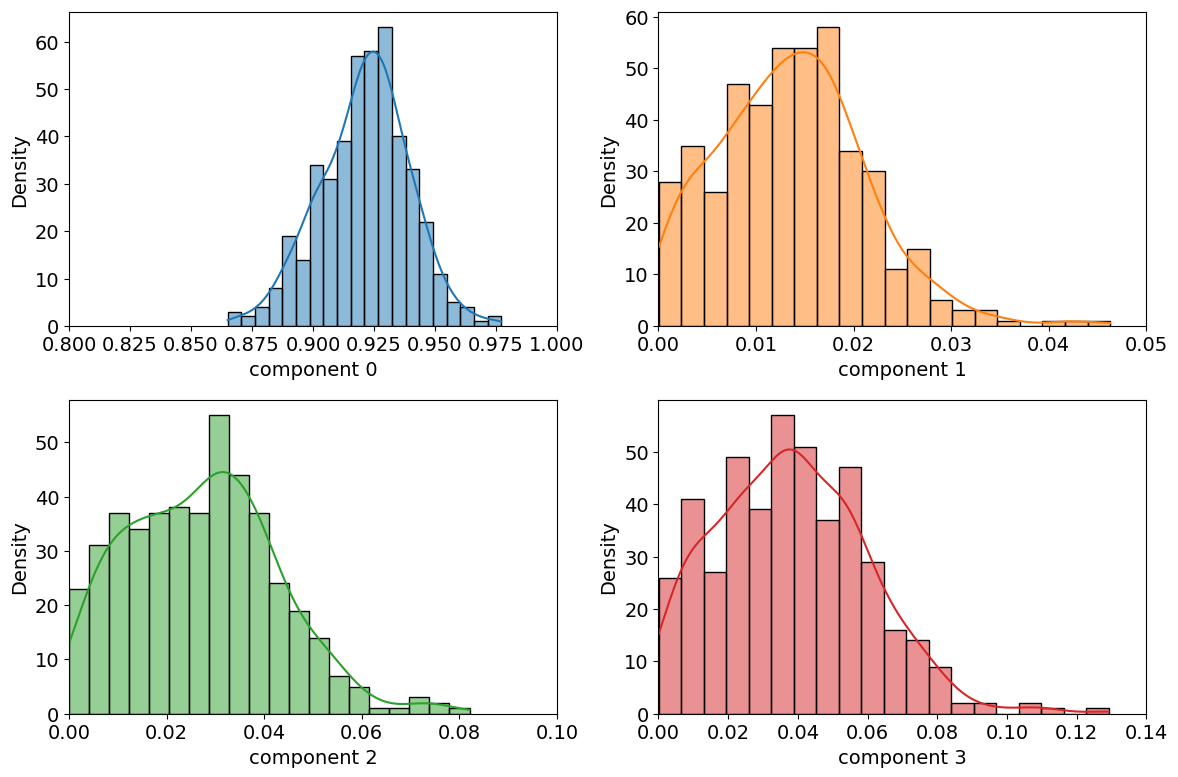

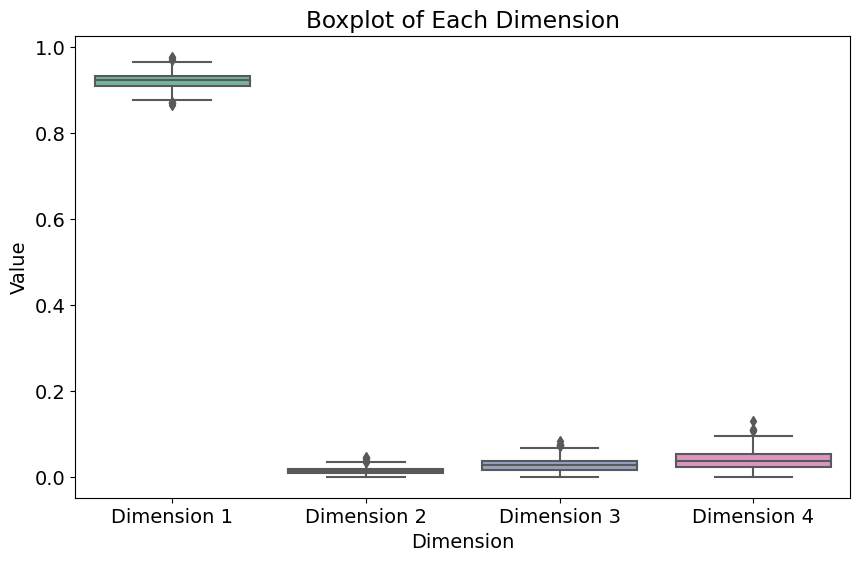

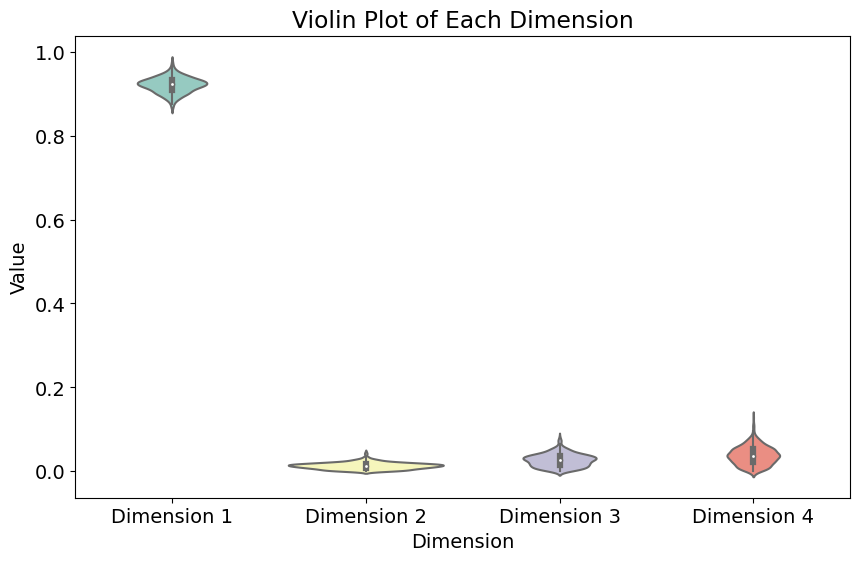

In [8]:
# Combine all samples into a single array (shape: num_seeds * n_samp, n_dim)
combined_samples = all_scaled_samples.reshape(-1, n_dim)

# Plot settings
#sns.set(style="whitegrid")
dim_labels = [f"Dimension {i+1}" for i in range(n_dim)]

# Plot 1: Histograms for each dimension
plt.figure(figsize=(12, 8))
for i in range(n_dim):
    ax = plt.subplot(2, 2, i + 1)
    sns.histplot(combined_samples[:, i], bins=20, kde=True, color=f"C{i}")
    #ax.set_title(f"Histogram of {dim_labels[i]}")
    ax.set_xlabel(f"component {i}")
    ax.set_ylabel("Density")
    if bounds is not None and i < len(bounds):
        ax.set_xlim(bounds[i])  # Correct way to set x-limits for each subplot
plt.tight_layout()
plt.show()


# Plot 2: Boxplot for each dimension
plt.figure(figsize=(10, 6))
sns.boxplot(data=combined_samples, palette="Set2")
plt.title("Boxplot of Each Dimension")
plt.xlabel("Dimension")
plt.ylabel("Value")
plt.xticks(range(n_dim), dim_labels)
plt.show()

# Plot 3: Violin Plot for Each Dimension
plt.figure(figsize=(10, 6))
sns.violinplot(data=combined_samples, palette="Set3")
plt.title("Violin Plot of Each Dimension")
plt.xlabel("Dimension")
plt.ylabel("Value")
plt.xticks(range(n_dim), dim_labels)
plt.show()

In [9]:
uniform_samples2 = select_most_uniform_samples(combined_samples, num_samples=90)
print(f"Shape of uniform samples: {uniform_samples2.shape}")

Shape of uniform samples: (90, 4)


In [10]:
all_val_samples_mdu = uniform_samples2

### Import data and format

In [11]:
filename = '../../../CASTRO/examples/data/Bank_Data-2808_mod_corrected.csv'
df = pd.read_csv(filename, sep=';', decimal=",")
#df = df.replace(',','.', regex=True)
df = df.div(100.)
data_array = np.zeros((len(df),dim))
data_array = np.column_stack((df['PA-56'].to_numpy(), df['PhA'], df['am-based'], df['met-based']))


#### Standardize data

In [12]:
scaler = StandardScaler().fit(data_array)
data_scaled = scaler.transform(data_array)
scaler2 = StandardScaler().fit(all_val_samples)
all_val_samples_scaled = scaler2.transform(all_val_samples)
scaler3 = StandardScaler().fit(all_val_samples_mdu)
all_val_samples_mdu_scaled = scaler3.transform(all_val_samples_mdu)

### Transform with PCA and plot first two dimensions which are the most informative ones, for both LHS samples and Data

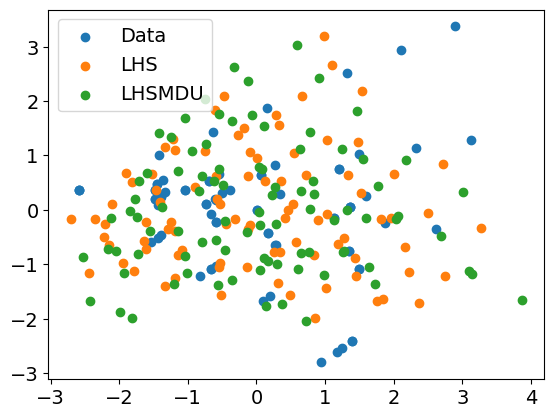

In [13]:
pca = PCA(n_components=2)
Xt1 = pca.fit_transform(data_scaled)
Xt2 = pca.fit_transform(all_val_samples_scaled)
Xt3 = pca.fit_transform(all_val_samples_mdu_scaled)
#y = np.zeros((1,n_samp*4))
#y[0,0:n_samp] = 0
#y[0,n_samp:n_samp*2] = 1
#y[0,n_samp*2:n_samp*3] = 2
#y[0,n_samp*3:n_samp*4] = 3
# y = np.zeros((1, dim))
# y[0,0] = (0.8+1)/2
# y[0,1] = 0.2/2
# y[0,2] = 0.2/2
# y[0,3] = 0.2/2
# print(y)
plt.scatter(Xt1[:,0], Xt1[:,1])
#plt.legend(handles=plot.legend_elements()[0])#, labels=['PA56', 'PhA', 'am-based', 'met-based'])
plt.scatter(Xt2[:,0], Xt2[:,1])
plt.scatter(Xt3[:,0], Xt3[:,1])
plt.legend(['Data', 'LHS', 'LHSMDU'])
plt.show()



In [14]:
print(len(Xt2), len(Xt3))

90 90


In [15]:
#print(len(Xt1))
for i in range(len(Xt2)):
    if (Xt2[i,1]>-0.06 and Xt2[i,1]<-0.04 and Xt2[i,0]< -0.1):
        print(Xt2[i,0],Xt2[i,1],Xt2[i,:],i)
        print('orig',all_val_samples[i,:])

### Transform with PCA and plot first two dimensions which are the most informative ones, for both LHS samples and Data

#### Select subset of samples that varies the most in terms of distance from the already collected data

In [16]:
tol = 1e-5
tol2 = 1e-5
des_n_samp = 15

tol_samples, tol_samples_LHSMDU, tol_samples_unscaled, tol_samples_LHSMDU_unscaled = select_samples_diff_from_data(exp_data=data_array, samples_LHS=all_val_samples, samples_LHSMDU=all_val_samples_mdu, des_n_samp = des_n_samp, tol = tol, tol2 = tol2)


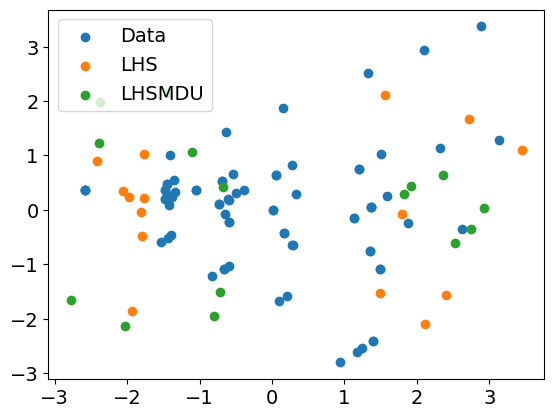

In [17]:
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_scaled)
lhs_samples_pca = pca.fit_transform(tol_samples)
lhsmdu_samples_pca = pca.fit_transform(tol_samples_LHSMDU)

plot_dimred_2dims_both_methods(data_pca, lhs_samples_pca, lhsmdu_samples_pca)

#### Test whether all selected samples are feasible

In [18]:
for i in range(len(tol_samples_unscaled)):
    for j in range(dim):
        if tol_samples_unscaled[i,j]<bounds[j][0] or tol_samples_unscaled[i,j]>bounds[j][1]:
            print("not feasible", tol_samples_unscaled[i,:])
print("-------------------")
for i in range(len(tol_samples_LHSMDU_unscaled)):
    for j in range(dim):
        if tol_samples_LHSMDU_unscaled[i,j]<bounds[j][0] or tol_samples_LHSMDU_unscaled[i,j]>bounds[j][1]:
            print("not feasible", tol_samples_LHSMDU_unscaled[i,:])

-------------------


In [19]:
df_15_samps_scaled = pd.DataFrame(tol_samples,columns=['PA-56','PhA','am-based','met-based'])
df_15_samps = pd.DataFrame(tol_samples_unscaled,columns=['PA-56','PhA','am-based','met-based'])

#### Check if add up to 100%

In [20]:
df_perc = df_15_samps*100
for i in range(len(df_15_samps)):
    if abs(df_15_samps.iloc[i,:].sum()-1)>1e-4:
        ind_list = np.where(df_15_samps.iloc[i,:]!=0)[0]
        ind = np.random.choice(ind_list)
        df_15_samps.iloc[i,ind] = df_15_samps.iloc[i,ind] - (df_15_samps.iloc[i,:].sum()-1)

In [21]:
df_perc

,PA-56,PhA,am-based,met-based
0,89.0,1.4,4.6,5.0
1,90.2,1.4,6.4,2.0
2,94.9,2.8,0.1,2.2
3,87.6,0.4,2.3,9.7
4,99.7,0.0,0.1,0.2
5,95.2,2.8,1.1,0.8
6,90.1,0.6,7.4,1.9
7,88.3,1.7,1.2,8.8
8,89.4,0.5,6.9,3.2
9,92.5,4.4,0.5,2.5


### **7. Distribution plots**

#### Distribution subplots of unscaled data: first 90 pts, then 15 pts

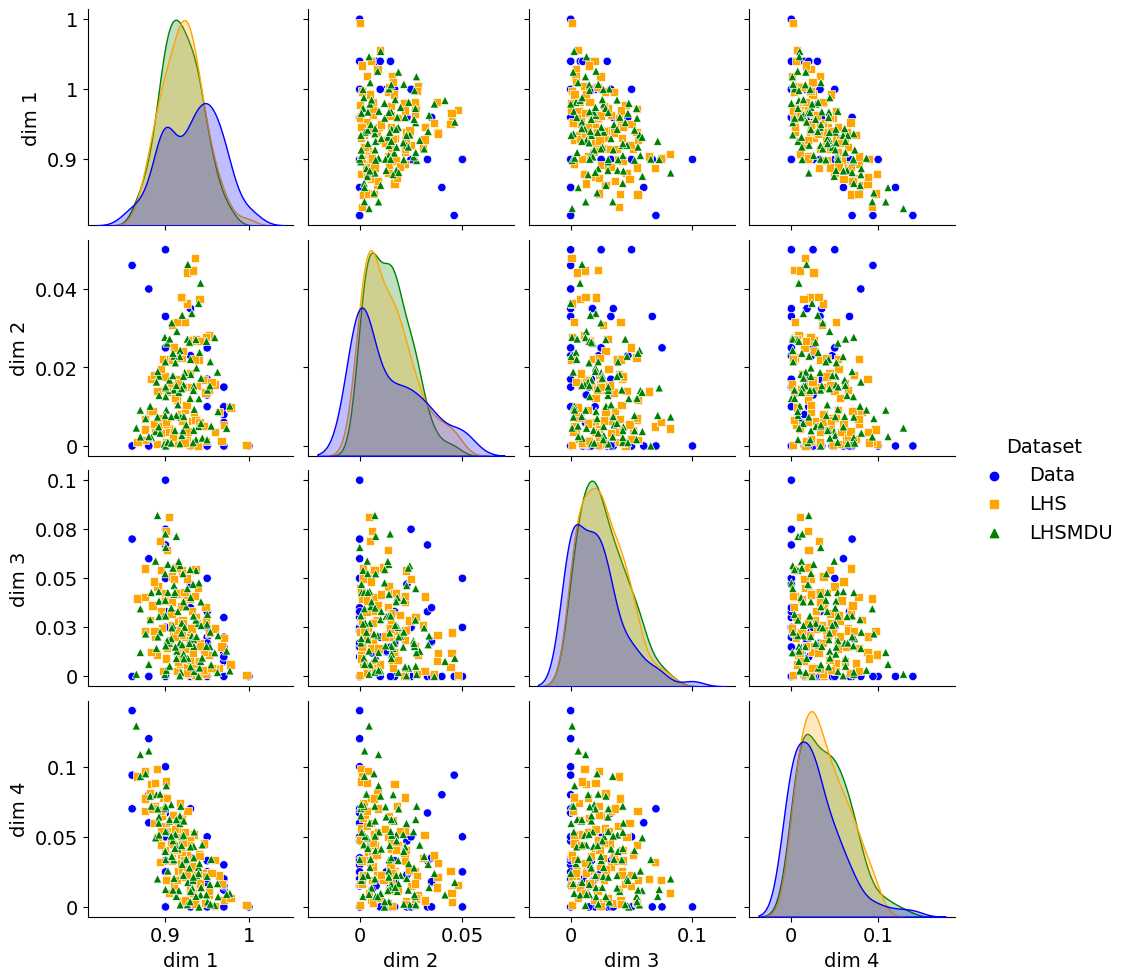

In [22]:
l_bounds = [0.8, 0, 0, 0]
u_bounds = [1., 0.05, 0.1, 0.14]
bounds = [[lb, ub] for lb, ub in zip(l_bounds, u_bounds)]
create_pairwise_distribution_plots_seaborn(data_array, all_val_samples, all_val_samples_mdu, markers=["o", "s", "^"], filename_eps="pairwise_distributionsLHS_LHSMDU_90pts_4dim.png")

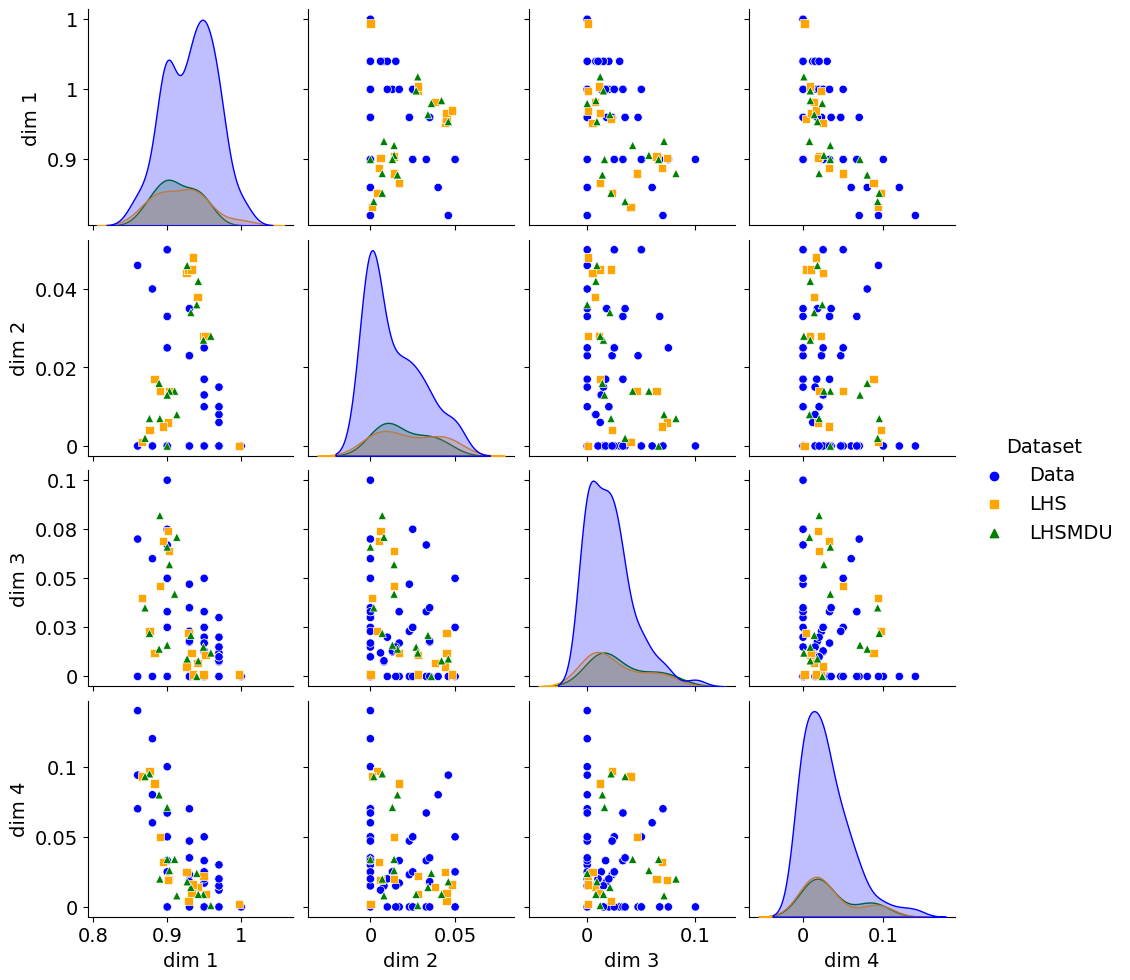

In [23]:
l_bounds = [0.8, 0, 0, 0]
u_bounds = [1., 0.05, 0.1, 0.14]
bounds = [[lb, ub] for lb, ub in zip(l_bounds, u_bounds)]
create_pairwise_distribution_plots_seaborn(data_array, tol_samples_unscaled, tol_samples_LHSMDU_unscaled, markers=["o", "s", "^"], filename_eps="pairwise_distributionsLHS_LHSMDU_15pts_4dim.png")

### **8. Discrepancy for LHS and LHSMDU with mixture constraint sum=1**

In [24]:
l_bounds = [0.8, 0, 0, 0]
u_bounds = [1., 0.05, 0.1, 0.14]
space = qmc.scale(all_val_samples, l_bounds, u_bounds, reverse=True)
qmc.discrepancy(space)

0.2941195721745711

In [25]:
qmc.discrepancy(space, method='WD')


0.3172252816748973

In [26]:
np.linalg.norm(space.var())

0.055606139998835895

In [27]:
space = qmc.scale(all_val_samples_mdu, l_bounds, u_bounds, reverse=True)
qmc.discrepancy(space)

0.27513823523142533

In [28]:
qmc.discrepancy(space, method='WD')

0.322000872330936

In [29]:
np.linalg.norm(space.var())

0.05117991622158602

In [30]:
tol_samples_unscaled

array([[0.89 , 0.014, 0.046, 0.05 ],
       [0.902, 0.014, 0.064, 0.02 ],
       [0.949, 0.028, 0.001, 0.022],
       [0.876, 0.004, 0.023, 0.097],
       [0.997, 0.   , 0.001, 0.002],
       [0.952, 0.028, 0.011, 0.009],
       [0.901, 0.006, 0.074, 0.019],
       [0.883, 0.017, 0.012, 0.088],
       [0.894, 0.005, 0.069, 0.032],
       [0.926, 0.044, 0.005, 0.025],
       [0.941, 0.038, 0.007, 0.014],
       [0.866, 0.001, 0.04 , 0.093],
       [0.929, 0.045, 0.022, 0.004],
       [0.933, 0.045, 0.012, 0.01 ],
       [0.935, 0.048, 0.001, 0.016]])

In [31]:
space = qmc.scale(df_15_samps, l_bounds, u_bounds, reverse=True)
qmc.discrepancy(space)

0.3038074878435737

In [32]:
qmc.discrepancy(space, method='WD')

0.2969700926275638

In [33]:
np.linalg.norm(space.var())

0.08682554195011333

In [34]:
df_data = df[['PA-56','PhA','am-based','met-based']].copy()
df_data = df_data
df_with_data = pd.concat([df_15_samps, df_data], ignore_index=True, axis=0)

In [35]:
space = qmc.scale(df_with_data, l_bounds, u_bounds, reverse=True)
qmc.discrepancy(space)#default CD

0.42840089815163207

In [36]:
qmc.discrepancy(space, method='WD')

0.30869821758721505

In [37]:
np.linalg.norm(space.var())

0.09009924200050388

In [38]:
df_15_samps_mdu = pd.DataFrame(tol_samples_LHSMDU_unscaled,columns=['PA-56','PhA','am-based','met-based'])
df_15_samps_mdu_scaled = pd.DataFrame(tol_samples_LHSMDU,columns=['PA-56','PhA','am-based','met-based'])
space = qmc.scale(df_15_samps_mdu, l_bounds, u_bounds, reverse=True)
qmc.discrepancy(space)

0.22821016018839502

In [39]:
qmc.discrepancy(space, method='WD')

0.2854632390682248

In [40]:
np.linalg.norm(space.var())

0.06682759297052153

In [41]:
df_lhsmdu_with_data = pd.concat([df_15_samps_mdu, df_data], ignore_index=True, axis=0)

In [42]:
space = qmc.scale(df_lhsmdu_with_data, l_bounds, u_bounds, reverse=True)
qmc.discrepancy(space)#default CD

0.4135383226006377

In [43]:
qmc.discrepancy(space, method='WD')

0.3000039876554994

In [44]:
np.linalg.norm(space.var())

0.08673283956916097

#### Distribution subplots of unscaled data: 15pts plus data

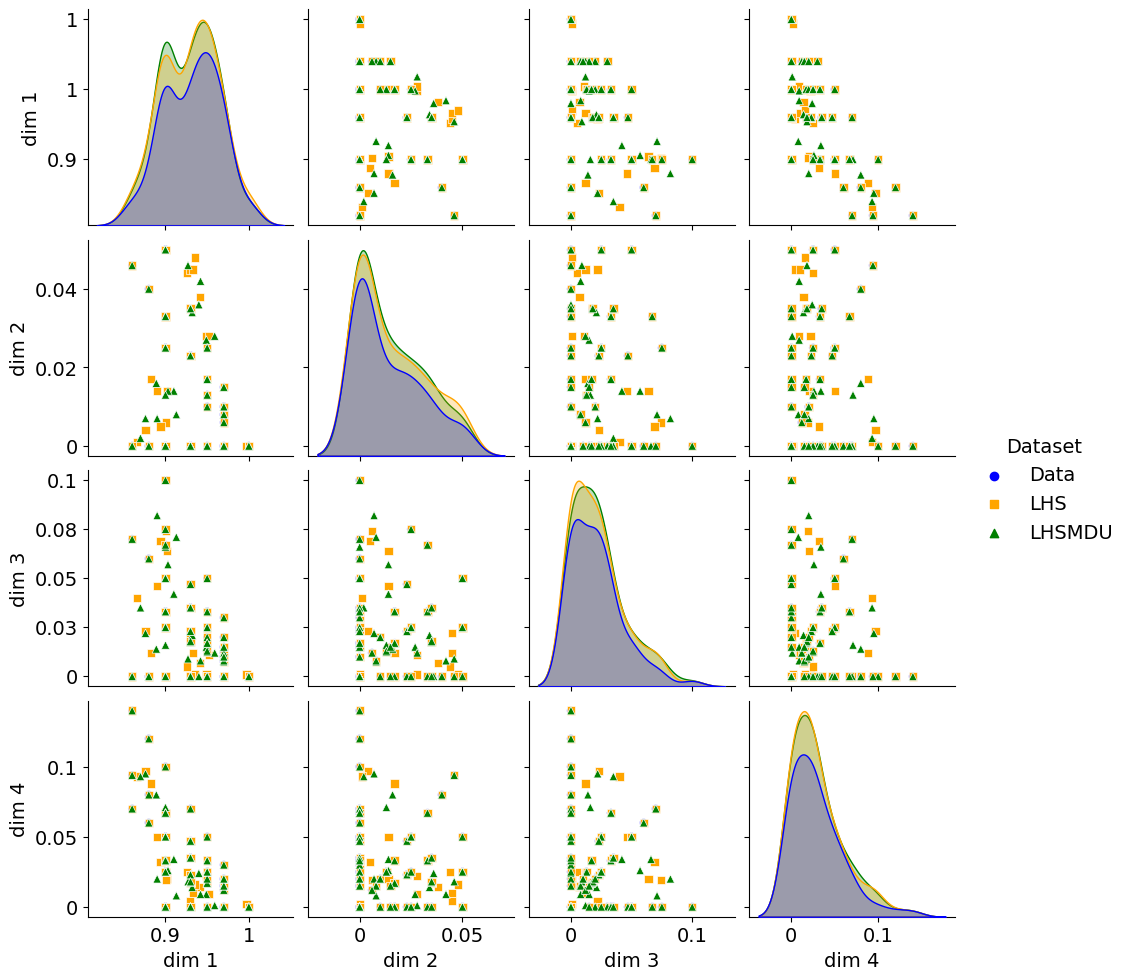

In [45]:
create_pairwise_distribution_plots_seaborn(data_array, np.array(df_with_data), np.array(df_lhsmdu_with_data), markers=["o", "s", "^"], filename_eps="pairwise_distributionsLHS_LHSMDU_15ptsplusdata_4dim.png")